In [163]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
%matplotlib inline

In [125]:
def read_file():
    '''
    Read the csv file containing info about dataset
    :param base_path: base path to source images
    :return: list of images path
    '''
    lines = []
    with open('simulator_outputs/track_1/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    return lines

In [6]:
def read_file(base_path):
    '''
    Read the csv file containing info about dataset
    :param base_path: base path to source images
    :return: list of images path
    '''
    lines = []
    with open(base_path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    return lines

def preprare_dataset(base_path, lines):
    '''
    Reads images and the respective value of the steering angle
    :param base_path: base path to source file
    :param lines: list of paths to source images
    :return: features, labels and shape of the input images
    '''
    images = []
    steering_measurements = []
    i=0
    for line in lines:
        # i+=1
        # if i < 500:
        center_camera_image = line[0]
        left_camera_image = line[1]
        right_camera_image = line[2]

        filename_c = center_camera_image.split('/')[-1]
        filename_l = left_camera_image.split('/')[-1]
        filename_r = right_camera_image.split('/')[-1]

        path_c = base_path + 'IMG/' + filename_c
        path_l = base_path + 'IMG/' + filename_l
        path_r = base_path + 'IMG/' + filename_r

        image_c = cv2.imread(path_c)
        image_l = cv2.imread(path_l)
        image_r = cv2.imread(path_r)

        images.append(image_c)
        images.append(image_l)
        images.append(image_r)

        steering_center = float(line[3])
        steering_offset = 0.05

        steering_left = steering_center + steering_offset
        steering_right = steering_center - steering_offset

        steering_measurements.append(steering_center)
        steering_measurements.append(steering_left)
        steering_measurements.append(steering_right)

    features = np.array(images)
    labels = np.array(steering_measurements)
    #input_shape = features.shape[1:]

    return features, labels


base_path = 'simulator_outputs/track_1/'
lines = read_file(base_path)
features, labels = preprare_dataset(base_path, lines)

In [8]:
labels.shape

(6384,)

(array([   15.,    65.,   239.,   497.,  2080.,  3376.,    52.,    32.,
           15.,    13.]),
 array([-0.7166291 , -0.57496618, -0.43330326, -0.29164034, -0.14997742,
        -0.0083145 ,  0.13334842,  0.27501134,  0.41667426,  0.55833718,
         0.7000001 ]),
 <a list of 10 Patch objects>)

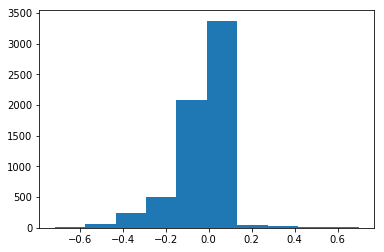

In [12]:
plt.hist(labels)

## Change the brightness of the image

In [240]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

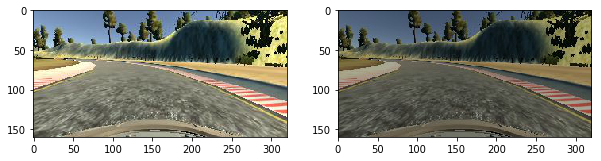

In [241]:
input_img = mpimg.imread('simulator_outputs/track_1/IMG/center_2017_04_15_14_29_12_291.jpg')
img = augment_brightness_camera_images(input_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(input_img)
ax2.imshow(img)

## Horizontal/Vertical shift

####  We added 0.004 steering angle units per pixel shift to the right, and subtracted 0.004 steering angle units per pixel shift to the left. We will also shift the images vertically by a random number to simulate the effect of driving up or down the slope.

In [242]:
def trans_image(image,steer,trans_range):
    
    cols = 5
    rows = 5
        
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

TypeError: Image data can not convert to float

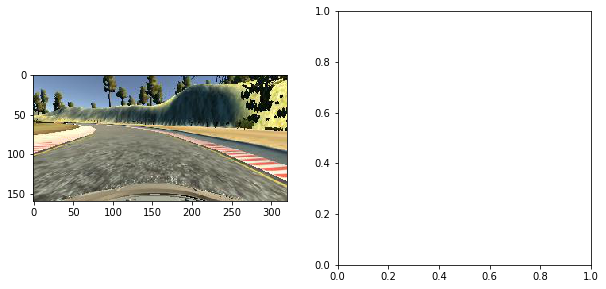

In [243]:
img = trans_image(input_img, labels, 5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(input_img)
ax2.imshow(img)

## Shadow augmentation
#### The next augmentation we will add is shadow augmentation where random shadows are cast across the image. This is implemented by choosing random points and shading all points on one side (chosen randomly) of the image. The code for this augmentation is presented below.

In [244]:
def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]

    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    random_bright = .25+.7*np.random.uniform()
    
    if np.random.randint(2)==1:
    #    random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)

    return image

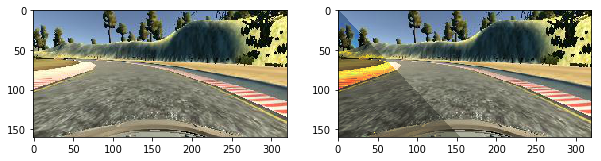

In [245]:
img = add_random_shadow(input_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(input_img)
ax2.imshow(img)

## Flipping

#### In addition to the transformations above, we will also flip images at random and change the sign of the predicted angle to simulate driving in the opposite direction.

In [246]:
def flip_image(img):
    return cv2.flip(img,1)

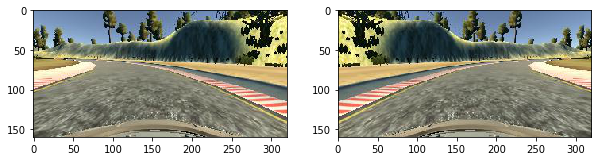

In [247]:
img = flip_image(input_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(input_img)
ax2.imshow(img)

## Preprocessing

#### After augmenting the image as above, we will crop the top 1/5 of the image to remove the horizon and the bottom 25 pixels to remove the car’s hood. Originally 1/3 of the top of car image was removed, but later it was changed to 1/5 to include images for cases when the car may be driving up or down a slope. We will next rescale the image to a 64X64 square image. After augmentation, the augmented images looks as follows. These images are generated using kera’s generator, and unlimited number of images can be generated from one image. I used Lambda layer in keras to normalize intensities between -.5 and .5.

In [248]:
new_size_col,new_size_row = 220, 66

def preprocessImage(image):
    shape = image.shape
    image = image[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)    
    return image

def preprocess_image_file_train(line_data):
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = 'simulator_outputs/track_1/IMG/' + line_data[1].split('/')[-1]
        shift_ang = .25
    if (i_lrc == 1):
        path_file = 'simulator_outputs/track_1/IMG/' + line_data[0].split('/')[-1]
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = 'simulator_outputs/track_1/IMG/' + line_data[2].split('/')[-1]
        shift_ang = -.25
        
    y_steer = float(line_data[3]) + shift_ang
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #image,y_steer,tr_x = trans_image(image,y_steer,100)
    image = augment_brightness_camera_images(image)
    image = add_random_shadow(image)
    image = preprocessImage(image)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:        
        image = flip_image(image)
        y_steer = -y_steer
    
    return image,y_steer

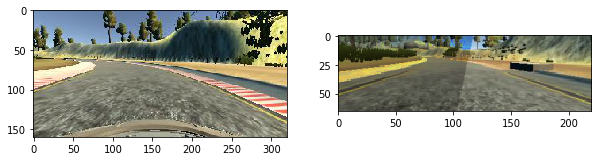

In [249]:
lines = read_file()
img,ysteer = preprocess_image_file_train(lines[100])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(input_img)
ax2.imshow(img)

## Keras generator for subsampling

#### As there was limited data and we are generating thousands of training examples from the same image, it is not possible to store all the images apriori into memory. We will utilize kera’s generator function to sample images such that images with lower angles have lower probability of getting represented in the data set. This alleviates any problems we may ecounter due to model having a bias towards driving straight. Panel below shows multiple training samples generated from one image. The keras generator is presented below. The ‘pr_threshold’ variable is a threshold that determines if a data with small angle will be dropped or not.

In [250]:
def generate_train_from_PD_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            
            #line_data = data.iloc[[i_line]].reset_index()
            line_data = data[i_line]
            
            keep_pr = 0
            #x,y = preprocess_image_file_train(line_data)
            while keep_pr == 0:
                x,y = preprocess_image_file_train(line_data)
                pr_unif = np.random
                if abs(y)<.1:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            #y = np.array([[y]])
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering

In [300]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

NB_EPOCHS=3
BATC_SIZE=128
LEARNING_RATE=0.0001
VALIDATION_SPLIT=0.2
REGULARIZATION_FACTOR=0.001
DROPOUT_PROB=0.2

activation_function = 'relu' #ELU();

fc1_output_size = 1164
fc2_output_size = 100
fc3_output_size = 50
fc4_output_size = 10
fc5_output_size = 1

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 220, 3)))
#model.add(Cropping2D(cropping=((70,24),(0,0))))
model.add(Convolution2D(24, (5, 5), strides=(2,2), activation=activation_function, kernel_regularizer=l2(REGULARIZATION_FACTOR)))
model.add(Convolution2D(36, (5, 5), strides=(2,2), activation=activation_function, kernel_regularizer=l2(REGULARIZATION_FACTOR)))
model.add(Convolution2D(48, (5, 5), strides=(2,2), activation=activation_function, kernel_regularizer=l2(REGULARIZATION_FACTOR)))
model.add(Convolution2D(64, (3, 3), activation=activation_function, kernel_regularizer=l2(REGULARIZATION_FACTOR)))
model.add(Convolution2D(64, (3, 3), activation=activation_function, kernel_regularizer=l2(REGULARIZATION_FACTOR)))
model.add((Flatten()))
model.add(Dense(1164, activation=activation_function, kernel_regularizer=l2(REGULARIZATION_FACTOR)))
model.add(Dropout(DROPOUT_PROB))
model.add(Dense(100, activation=activation_function, kernel_regularizer=l2(REGULARIZATION_FACTOR)))
model.add(Dropout(DROPOUT_PROB))
model.add(Dense(50, activation=activation_function, kernel_regularizer=l2(REGULARIZATION_FACTOR)))
model.add(Dropout(DROPOUT_PROB))
model.add(Dense(10, activation=activation_function, kernel_regularizer=l2(REGULARIZATION_FACTOR)))
model.add(Dropout(DROPOUT_PROB))
model.add(Dense(1))

model.compile(loss='mse',
               optimizer=Adam(lr=LEARNING_RATE),
               metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=1, verbose=0, mode='min')


val_size = 1
pr_threshold = 1

bathc_size = 256

for i in range(8):
    
    train_r_generator = generate_train_from_PD_batch(lines, bathc_size)
    
    nb_vals = np.round(len(lines)/val_size)-1
    
    model.fit_generator(train_r_generator,
                       steps_per_epoch=20000,
                       epochs=1)#,
                       #shuffle=True,
                       #validation_split=0.2,
                       #callbacks=[early_stopping_callback])
      
    pr_threshold = 1 / (i+1)

Epoch 1/1
    4/20000 [..............................] - ETA: 224868s - loss: 1.7499 - acc: 0.0000e+00

KeyboardInterrupt: 

In [ ]:


history_object = model.fit(
                    features, labels,
                    nb_epoch=NB_EPOCHS,
                    verbose=1,
                    shuffle=True,
                    validation_split=0.2,
                    callbacks=[early_stopping_callback])
# history_object = model.fit(
#                     features, labels,
#                     batch_size=BATC_SIZE,
#                     nb_epoch=NB_EPOCHS,
#                     verbose=1,
#                     shuffle=True,
#                     validation_split=0.2,
#                     callbacks=[early_stopping_callback])

#score = model.evaluate(X_test, y_test, verbose=0)

# print a summary representation of your model
# model.summary()

#print('Test score:', score[0])
#print('Test accuracy:', score[1])

# save the model
model.save('model.h5')

#print('Model history: ' + str(history_object.history))
#print('Model history keys: ' + str(history_object.history.keys()))

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('model_hisotry.png')

In [299]:
def test_generator(i):
    for j in range(i):
        yield j

gen = test_generator(10)
print(next(gen))
print(next(gen))
print(next(gen))

0
1
2
